In [1]:
import pandas as pd
import glob

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path_files = r"/content/drive/MyDrive/Data_M/"

Lire les données et les afficher avec pandas

In [4]:
data_hate = pd.read_pickle(f"{path_files}dataset_fr/data_hate.pkl")

In [5]:
data_hate.head(10)

,HITId,tweet,sentiment,text length,clean_tweet_min,clean_tweet_std,clean_tweet_lem
0,1,rt @user personnage ainsi q tte la clique gauc...,1,128,personnage ainsi q tte la clique gauchiste deg...,personnag tte cliqu gauchist deguis 1 macron!!...,personnage tout cliqu gauchiste deguise 1 macr...
1,2,@user @user @user bah oui t'as raison l'autre ...,1,62,bah oui t'as raison l'autre c'est un mongol.,raison mongol.,raison mongol.
2,3,moi j'ai personne à qui m'adresser pour réclam...,1,120,moi j'ai personne à qui m'adresser pour réclam...,m'adress réclam. voisin attard pu brui adminis...,me adresser réclamer. voisin attarder puant br...
3,4,@user @user c...est vrai que les anchois sont ...,0,102,c ... est vrai que les anchois sont aller sur ...,... vrai anchois aller lun invent million tech...,... vrai anchois aller lune invent million tec...
4,5,eh les renois faut se réveiller la @url,0,39,eh les renois faut se réveiller la,renois faut réveil,renois falloir réveiller
5,6,@user @user en algerie les migrants sont expul...,1,112,en algerie les migrants sont expulsés dans le ...,alger migr expuls désert crois bien qu'vision,algerie migrant expulser désert croi bien que ...
6,7,@user sjw et féministe twitter un sale combo,0,44,sjw et féministe twitter un sale combo,sjw fémin twitt sal combo,sjw féministe twitter sale combo
7,8,@user @user tu sais aussi pourquoi est au dess...,0,101,tu sais aussi pourquoi est au dessus? parce qu...,sais? veut ya d'ani ...,sai? vouloir ya de ani ...
8,9,@user @user mytho t'as juste voulu te faire ke...,1,105,mytho t'as juste voulu te faire ken par les re...,mytho voulu fair ken renois lyc voulu to,mytho vouloir faire ken renois lycer vouloir to
9,10,c’est un giga attardé mdrrr ils va vraiment se...,1,64,c’est un giga attardé mdrrr ils va vraiment se...,gig attard mdrrr va fair shoot,giga-octet attarder mdrrr aller faire shoote


In [6]:
target= data_hate["sentiment"]

In [ ]:
!pip install gensim==4.0
!pip install python-Levenshtein

In [8]:
from gensim.models.word2vec import Word2Vec
from gensim.models import KeyedVectors
import numpy as np

In [9]:
tweets=[line.split() for line in data_hate["clean_tweet_min"]]

Entrainer un modèle sur les données du dataset 4k

In [19]:
def encode(msg, model, dim):
    return np.mean([model[word] for word in msg if word in model] or [np.zeros(dim)], axis = 0)

In [11]:
# Feed a word2vec with the ingredients
model_w2v = Word2Vec(tweets, vector_size=300, window=5, min_count=2, workers=8, sg=1)

In [13]:
wv=model_w2v.wv
wv.save("model_dataset_fr")

In [14]:
# récupérer les embeddings entrainés sur nos données
w2v_data4k = KeyedVectors.load('model_dataset_fr')

In [27]:
X_2 = np.array([encode(msg, w2v_data4k, 300) for msg in tweets])

Importer le modèle w2v entrainé sur le dataset 1M

In [16]:
w2v = KeyedVectors.load(f"{path_files}w2v/w2vec_model_d300_global_Min")

In [17]:
w2v.similar_by_word("noir")

[('blanc', 0.6659490466117859),
 ('noir,', 0.6475639343261719),
 ('blanc,', 0.6131015419960022),
 ('roux', 0.6044836640357971),
 ('noir.', 0.603306770324707),
 ('bandeau', 0.5998969674110413),
 ('marron', 0.5980905890464783),
 ('beige', 0.5841408967971802),
 ('blanc.', 0.5792201161384583),
 ('noir?', 0.575861930847168)]

In [18]:
w2v_data4k.similar_by_word("noir")

[('traite', 0.9989169836044312),
 ('pute', 0.9984580874443054),
 ('merde', 0.9979943037033081),
 ('traiter', 0.9977803230285645),
 ('tes', 0.9977630376815796),
 ('ton', 0.9977055191993713),
 ('va', 0.9976930618286133),
 ('traité', 0.9976478219032288),
 ('es', 0.9975999593734741),
 ('arabe.', 0.9975348114967346)]

In [20]:
clean_dataset = tweets

In [25]:
X = np.array([encode(msg, w2v, 300) for msg in tweets])

In [26]:
X.shape

(4014, 300)

MODÈLE ENSEMBLISTE

In [33]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [29]:
model = Pipeline([
    (
        "classifier",
        HistGradientBoostingClassifier(
            random_state=42,scoring="balanced_accuracy"
        )
    ),
])

In [39]:
param_grid = {
    'classifier__learning_rate': [0.05, 0.5],    'classifier__max_leaf_nodes': (10, 30),
}
model_grid_search = GridSearchCV(
    model, param_grid=param_grid, n_jobs=2, cv=2
)
model_grid_search.fit(X, target)

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('classifier',
                                        HistGradientBoostingClassifier(random_state=42,
                                                                       scoring='balanced_accuracy'))]),
             n_jobs=2,
             param_grid={'classifier__learning_rate': [0.05, 0.5],
                         'classifier__max_leaf_nodes': (10, 30)})

In [42]:
cv_results = pd.DataFrame(model_grid_search.cv_results_)
cv_results[[
    "param_classifier__learning_rate",
    "param_classifier__max_leaf_nodes",
    "mean_test_score",
    "std_test_score",
    "rank_test_score"
]]

,param_classifier__learning_rate,param_classifier__max_leaf_nodes,mean_test_score,std_test_score,rank_test_score
0,0.05,10,0.791978,0.005232,1
1,0.05,30,0.786746,0.003986,2
2,0.5,10,0.775536,0.004733,4
3,0.5,30,0.784255,0.003488,3


In [43]:
cv_results = cross_validate(model, X, target, cv=5,scoring="balanced_accuracy")
cv_results = pd.DataFrame(cv_results)
cv_results

,fit_time,score_time,test_score
0,5.118547,0.014528,0.500215
1,5.074957,0.013691,0.500215
2,4.984132,0.013480,0.523985
3,5.081445,0.014374,0.528788
4,4.963029,0.013792,0.533279


In [45]:
model_grid_search.best_params_

{'classifier__learning_rate': 0.05, 'classifier__max_leaf_nodes': 10}

In [46]:
model_grid_search.best_estimator_


Pipeline(steps=[('classifier',
                 HistGradientBoostingClassifier(learning_rate=0.05,
                                                max_leaf_nodes=10,
                                                random_state=42,
                                                scoring='balanced_accuracy'))])

In [47]:
cv_results = cross_validate(
    model_grid_search.best_estimator_, X, target, cv=5, n_jobs=2, return_estimator=True,scoring="balanced_accuracy"
)

In [48]:
cv_results = pd.DataFrame(cv_results)
cv_test_scores = cv_results['test_score']
print(
    "Generalization score with hyperparameters tuning:\n"
    f"{cv_test_scores.mean():.3f} +/- {cv_test_scores.std():.3f}"
)

Generalization score with hyperparameters tuning:
0.512 +/- 0.005


Regression logistic+embedding

REGRESSION LOGISTIQUE SANS NORMALISATION

In [61]:
model_lr = Pipeline([                                   
    ('classifier', LogisticRegression(random_state=42,class_weight='balanced', max_iter= 10000))
])

In [62]:
cv_results = cross_validate(model_lr, X, target, cv=5)
cv_results = pd.DataFrame(cv_results)
cv_results

,fit_time,score_time,test_score
0,0.124421,0.001362,0.617684
1,0.117070,0.001274,0.622665
2,0.124730,0.001246,0.627646
3,0.143933,0.001301,0.591532
4,0.168118,0.001264,0.679551


In [63]:
cv_test_scores = cv_results['test_score']
print(
    "L'accuracy moyenne du la regression logistique sans normalisation est :"
    f"{cv_test_scores.mean():.3f} +/- {cv_test_scores.std():.3f}\n")

L'accuracy moyenne du la regression logistique sans normalisation est :0.628 +/- 0.032



RESGRESSION LOGISTIQUE AVEC NORMALISATION

In [64]:
model_lr_nr = Pipeline([
     ('scaler',MinMaxScaler()) ,                                    
    ('classifier', LogisticRegression(random_state=42,class_weight='balanced', max_iter= 10000))
])
  

In [65]:
cv_results_nr = cross_validate(model_lr_nr, X, target, cv=5)
cv_results_nr = pd.DataFrame(cv_results_nr)
cv_results_nr

,fit_time,score_time,test_score
0,0.766224,0.003330,0.623910
1,0.676094,0.002852,0.622665
2,0.821823,0.002813,0.616438
3,0.728328,0.002782,0.585305
4,0.765719,0.002861,0.678304


Comparaison

In [68]:
cv_test_scores_nr = cv_results_nr['test_score']
print(
    "L'accuracy moyenne du la regression logistique avec normalisation est :"
    f"{cv_test_scores_nr.mean():.3f} +/- {cv_test_scores_nr.std():.3f}\n"
    "L'accuracy moyenne du la regression logistique sans normalisation est :"
    f"{cv_test_scores.mean():.3f} +/- {cv_test_scores.std():.3f}\n")

L'accuracy moyenne du la regression logistique sans normalisation est :0.625 +/- 0.034
L'accuracy moyenne du la regression logistique sans normalisation est :0.628 +/- 0.032



Malgrè une différence minime sur les résultats , la moyenne des scores est meilleure sans normalisation .

Avec embedding entrainés sur les données de 1M

In [69]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'classifier__C': (0.1,1,5)}
model_grid_search_lr = GridSearchCV(model_lr, param_grid=param_grid,
                                 n_jobs=2, cv=10,scoring="balanced_accuracy")


In [70]:
model_grid_search_lr.fit(X, target)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('classifier',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=10000,
                                                           random_state=42))]),
             n_jobs=2, param_grid={'classifier__C': (0.1, 1, 5)},
             scoring='balanced_accuracy')

In [71]:
model_grid_search_lr.best_params_

{'classifier__C': 0.1}

In [72]:
cv_results_gs = pd.DataFrame(model_grid_search_lr.cv_results_)
cv_results_gs[[
    "param_classifier__C",
    "mean_test_score",
    "std_test_score",
    "rank_test_score"
]]

,param_classifier__C,mean_test_score,std_test_score,rank_test_score
0,0.1,0.661200,0.048074,1
1,1,0.632571,0.053228,2
2,5,0.611678,0.046515,3


In [73]:
cv_results_best = cross_validate(
    model_grid_search_lr.best_estimator_, X, target, cv=5, n_jobs=2, return_estimator=True,scoring="balanced_accuracy"
)

Embedding avec des données entrainé sur le dataset des 4k

In [78]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'classifier__C': (0.1,1,5,10)}
model_gs_lr_4k = GridSearchCV(model_lr, param_grid=param_grid,
                                 n_jobs=2, cv=10,scoring="balanced_accuracy")


In [79]:
model_gs_lr_4k.fit(X_2, target)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('classifier',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=10000,
                                                           random_state=42))]),
             n_jobs=2, param_grid={'classifier__C': (0.1, 1, 5, 10)},
             scoring='balanced_accuracy')

In [80]:
model_gs_lr_4k.best_params_

{'classifier__C': 10}

In [81]:
cv_results_4k = pd.DataFrame(model_gs_lr_4k.cv_results_)
cv_results_4k[[
    "param_classifier__C",
    "mean_test_score",
    "std_test_score",
    "rank_test_score"
]]

,param_classifier__C,mean_test_score,std_test_score,rank_test_score
0,0.1,0.553334,0.039253,4
1,1,0.579673,0.045679,3
2,5,0.615336,0.035721,2
3,10,0.619168,0.039290,1


In [82]:
cv_results_4k = cross_validate(
    model_gs_lr_4k.best_estimator_, X, target, cv=5, n_jobs=2, return_estimator=True,scoring="balanced_accuracy"
)

Comparaison

In [84]:
cv_test_scores = cv_results_best['test_score']
print(
    "L'accuracy moyenne du la regression logistique avec embedding entrainés sur le dataset 1M est :"
    f"{cv_test_scores.mean():.3f} +/- {cv_test_scores.std():.3f}\n")

L'accuracy moyenne du la regression logistique avec embedding entrainés sur le dataset 1M est :0.659 +/- 0.038



In [85]:
cv_test_scores_4k = cv_results_4k['test_score']
print(
    "L'accuracy moyenne du la regression logistique sans normalisation est :"
    f"{cv_test_scores_4k.mean():.3f} +/- {cv_test_scores_4k.std():.3f}"
)

L'accuracy moyenne du la regression logistique sans normalisation est :0.595 +/- 0.025


Meilleures résultats avec regression logistique +embedding entrainés sur le dataset 1M VS dataset 4k 0.659 contre 0.595

In [86]:
y_pred = cross_val_predict(model_grid_search_lr.best_estimator_, X, target, cv=10)
conf_mat = confusion_matrix(target, y_pred)

In [87]:
y_pred_4k = cross_val_predict(model_gs_lr_4k.best_estimator_, X_2, target, cv=10)
conf_mat_4k = confusion_matrix(target, y_pred_4k)

In [88]:
def draw_mat(conf_mat,string):
  print(string)
  matrice_proportions = np.zeros((2,2))
  for i in range(0,2):
      matrice_proportions[i,:] = conf_mat[i,:]/float(conf_mat[i,:].sum())
  names=['Neutre','Haineux']
  confusion_df = pd.DataFrame(matrice_proportions, index=names,columns=names)
  plt.figure(figsize=(5,5))
  sns.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='YlGnBu',cbar=False, square=True,fmt='.2f')
  plt.ylabel(r'Valeur réelle',fontsize=14)
  plt.xlabel(r'Valeur prédite',fontsize=14)
  plt.tick_params(labelsize=12)

matrice de confusion : LR avec embedding entrainé sur le dataset 1M


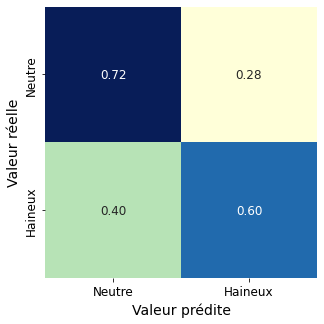

In [91]:
draw_mat(conf_mat, "matrice de confusion : LR avec embedding entrainé sur le dataset 1M")

matrice de confusion : LR avec embedding entrainé sur le dataset 4k


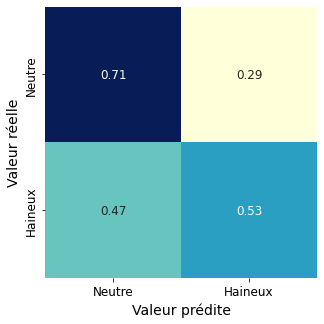

In [90]:
draw_mat(conf_mat_4k, "matrice de confusion : LR avec embedding entrainé sur le dataset 4k")

Detection d'anomalies

In [79]:
from sklearn.metrics import classification_report,accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from pylab import rcParams

In [80]:
##Define the outlier detection methods

classifiers = {
    "Isolation Forest":IsolationForest(n_estimators=100, 
                                       contamination=0.2, random_state=5, verbose=0),
    "Local Outlier Factor":LocalOutlierFactor(n_neighbors=20, algorithm='auto', 
                                              leaf_size=30, metric='minkowski',
                                              p=2, metric_params=None, contamination=0.2),
    "Support Vector Machine":OneClassSVM(kernel='rbf', degree=3, gamma=0.1,nu=0.05, 
                                         max_iter=-1)
   
}

In [85]:
def multiple_non_supervised_models(X):
  for i, (clf_name,clf) in enumerate(classifiers.items()):
      #Fit the data and tag outliers
      if clf_name == "Local Outlier Factor":
          y_pred = clf.fit_predict(X)
          scores_prediction = clf.negative_outlier_factor_
      elif clf_name == "Support Vector Machine":
          clf.fit(X)
          y_pred = clf.predict(X)
      else:    
          clf.fit(X)
          scores_prediction = clf.decision_function(X)
          y_pred = clf.predict(X)
      #Reshape the prediction values to 0 for Valid transactions , 1 for Fraud transactions
      y_pred[y_pred == 1] = 1
      y_pred[y_pred == -1] = 0
      n_errors = (y_pred != target).sum()
      # Run Classification Metrics
      print("{}: {}".format(clf_name,n_errors))
      print("Accuracy Score :")
      print(accuracy_score(target,y_pred))
      print("Classification Report :")
      print(classification_report(target,y_pred))

In [86]:
multiple_non_supervised_models(X)

Isolation Forest: 1358
Accuracy Score :
0.661684105630294
Classification Report :
              precision    recall  f1-score   support

           0       0.17      0.16      0.16       821
           1       0.79      0.79      0.79      3193

    accuracy                           0.66      4014
   macro avg       0.48      0.48      0.48      4014
weighted avg       0.66      0.66      0.66      4014

Local Outlier Factor: 1322
Accuracy Score :
0.6706527154957648
Classification Report :
              precision    recall  f1-score   support

           0       0.19      0.18      0.19       821
           1       0.79      0.80      0.79      3193

    accuracy                           0.67      4014
   macro avg       0.49      0.49      0.49      4014
weighted avg       0.67      0.67      0.67      4014

Support Vector Machine: 951
Accuracy Score :
0.7630792227204783
Classification Report :
              precision    recall  f1-score   support

           0       0.18      0.05 

In [87]:
from tensorflow import keras
import random

In [88]:
autoencoder = keras.models.load_model(f"{path_files}dataset_fr/autoencoder/ae_Min_feature_extr")

In [89]:
inp = keras.Input(shape=(300,))
outp = autoencoder.layers[1](inp)
outp = autoencoder.layers[2](outp)
outp = autoencoder.layers[3](outp)
encoder = keras.Model(inp, outp)

In [90]:
dataset_16_features = encoder.predict(X)

In [91]:
X_ae= dataset_16_features

In [92]:
multiple_non_supervised_models(X_ae)

Isolation Forest: 1366
Accuracy Score :
0.6596910812157449
Classification Report :
              precision    recall  f1-score   support

           0       0.16      0.16      0.16       821
           1       0.78      0.79      0.79      3193

    accuracy                           0.66      4014
   macro avg       0.47      0.47      0.47      4014
weighted avg       0.66      0.66      0.66      4014

Local Outlier Factor: 1268
Accuracy Score :
0.6841056302939711
Classification Report :
              precision    recall  f1-score   support

           0       0.22      0.22      0.22       821
           1       0.80      0.80      0.80      3193

    accuracy                           0.68      4014
   macro avg       0.51      0.51      0.51      4014
weighted avg       0.68      0.68      0.68      4014

Support Vector Machine: 968
Accuracy Score :
0.7588440458395616
Classification Report :
              precision    recall  f1-score   support

           0       0.13      0.03